In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model
from bertopic import BERTopic
from TopicTuner.topictuner import TopicModelTuner as TMT
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix
sys.path.append("../")
from TweetNormalizer import normalizeTweet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(sys.path)

['/sise/home/shouei/HateRecognition/target_model', '/home/shouei/.conda/envs/bert2vec/lib/python38.zip', '/home/shouei/.conda/envs/bert2vec/lib/python3.8', '/home/shouei/.conda/envs/bert2vec/lib/python3.8/lib-dynload', '', '/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages', 'HateRecognition/target_model/', '../']


In [4]:
# sys.path.append("./HateRecognition/data/")
df = pd.read_csv(r'../data/parler_annotated_data.csv')
df

,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,3.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,4.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,1.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,3.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,1.50,False
...,...,...,...,...
10116,bd2e05ec9a7942b78fbedab3d75d1079,Minneapolis City Council Votes To Eliminate Po...,1.00,False
10117,23ce3d9f0f09448abe4665b93dab2aef,And just like that facebook is gone,1.00,False
10118,163f0fad195c4cb58ef31920921a1ab9,Obama Says He Will Campaign For Biden If He Ca...,1.00,False
10119,ca70cdcc29084720990fc21ca6a3e31d,Shoup Voting Machine,1.00,False


In [5]:
%pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [15]:
from cleantext import clean

In [13]:
df.text = df.text.apply(normalizeTweet)
df

,id,text,label_mean,disputable_post,lang
49,991dbab436b54d9b829df42f002748a1,"Now the blacks not only want welfare , free co...",5.0,False,en
66,2120be390d02480ba91a41c6cc99d621,LISTENING TO CHUCKIE AND PELOSI ABOYT ISIS ! I...,5.0,False,en
116,06105fc7f89c4488a585c5c2c6813e85,Chuck Schumer : â   Weâ   re Nothing If We...,5.0,False,en
184,de6c9ee12daf48c5b68d5be4572e18e9,"I hate Muslims . I hate democrats , they are t...",5.0,False,en
300,10f9d6ff0aa045b9bb2e39d0d0e8afcb,HER AND THE BLM CAN GO TO HELL THEY ARE A TERR...,5.0,False,en
...,...,...,...,...,...
9824,3a8d9b093ca241a78b4c11978bc4925b,"To all of the get what you can take , donâ  ...",5.0,False,en
9836,04c69223f14d40658d1ccdcd11715548,BLM is a Palestinian terrorist organization . ...,5.0,False,en
9895,42f8558247e341379f820c3f875517e5,What is Kamala a woman or a man ? She 's the c...,5.0,False,en
9978,a2bd3d4710ab412a9beef2571b213d78,NOTHING NAME DEMOCRAT ... SHOULD BE ALLOWED TO...,5.0,False,en


In [16]:
df.text = df.text.apply(clean, no_emoji=True)
df

,id,text,label_mean,disputable_post,lang
49,991dbab436b54d9b829df42f002748a1,"now the blacks not only want welfare , free co...",5.0,False,en
66,2120be390d02480ba91a41c6cc99d621,listening to chuckie and pelosi aboyt isis ! i...,5.0,False,en
116,06105fc7f89c4488a585c5c2c6813e85,chuck schumer : ~ we (tm) re nothing if we (tm...,5.0,False,en
184,de6c9ee12daf48c5b68d5be4572e18e9,"i hate muslims . i hate democrats , they are t...",5.0,False,en
300,10f9d6ff0aa045b9bb2e39d0d0e8afcb,her and the blm can go to hell they are a terr...,5.0,False,en
...,...,...,...,...,...
9824,3a8d9b093ca241a78b4c11978bc4925b,"to all of the get what you can take , don (tm)...",5.0,False,en
9836,04c69223f14d40658d1ccdcd11715548,blm is a palestinian terrorist organization . ...,5.0,False,en
9895,42f8558247e341379f820c3f875517e5,what is kamala a woman or a man ? she 's the c...,5.0,False,en
9978,a2bd3d4710ab412a9beef2571b213d78,nothing name democrat ... should be allowed to...,5.0,False,en


In [8]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
# text = 'This is an english text.'
# doc = nlp(text)
# print(doc._.language)

In [9]:
df['lang'] = df.text.apply(lambda x: nlp(x)._.language['language'])
df['lang']

49      en
66      en
116     en
184     en
300     en
        ..
9824    en
9836    en
9895    en
9978    en
9981    en
Name: lang, Length: 369, dtype: object

In [10]:
df = df[df['lang']=='en']

In [17]:
topic_model = BERTopic.load('./topic_model_with_other')
# topics, probs = topic_model.fit_transform(hate_df.text)

In [18]:
topics, probs = topic_model.transform(df.text.values.tolist())

In [19]:
df['topics'] = [topic_model.topic_names[x] for x in topics]
df['topics'] 

49      0_nigger_white_niggers_like
66      1_moslem_muslim_sand_number
116     1_moslem_muslim_sand_number
184     1_moslem_muslim_sand_number
300           2_kike_jews_jew_white
                   ...             
9824    1_moslem_muslim_sand_number
9836    0_nigger_white_niggers_like
9895    -1_user_nigger_number_white
9978    1_moslem_muslim_sand_number
9981          2_kike_jews_jew_white
Name: topics, Length: 367, dtype: object

<AxesSubplot:>

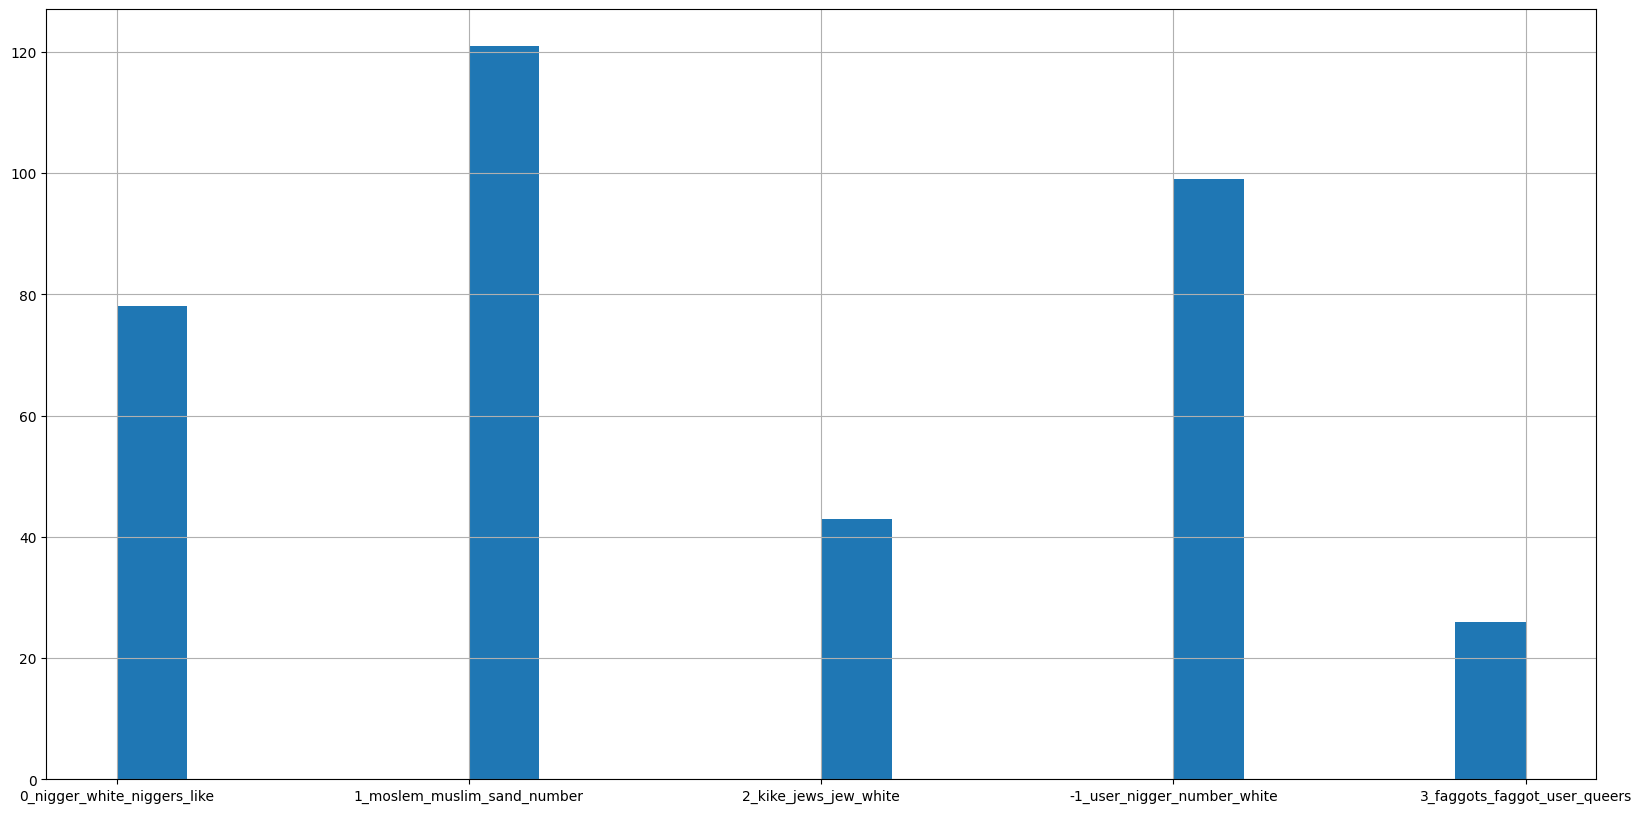

In [20]:
df['topics'].hist(figsize=(20,10),bins=20)

In [21]:
model = BertForSequenceClassification.from_pretrained(
    'finetune_plain/'    
)


In [22]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [23]:
token_id = []
attention_masks = []
text = df.text.values.tolist()
with_topic=False
MAX_LEN = max([len(x.split()) for x in text])
print(MAX_LEN)
for i, sample in enumerate(text):
  topic_name = None
  if with_topic:
    topic_id = topics[i]
    topic_name = topic_model.topic_names[topic_id]
    topic_name = ' '.join(topic_name.split('_')[1:])
  encoding_dict = preprocessing(sample,tokenizer, MAX_LEN, topic_name)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)

385


In [24]:

batch_size = 16


In [25]:
train_set = TensorDataset(token_id, 
                              attention_masks)

data = DataLoader(
                train_set,
                sampler = SequentialSampler(train_set),
                batch_size = batch_size
            )

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()
model.to('cuda')
pred_labels = []
for batch in data:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
        preds = torch.argmax(eval_output.logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())

In [27]:
labl_dict = {0:'African', 1:'Homosexual', 2:'Islam', 3:'Jewish',4:'other'}

In [28]:
df['pred'] = [labl_dict[x] for x in pred_labels]
df['pred'] 

49      African
66       Jewish
116       other
184       Islam
300       other
         ...   
9824      other
9836      Islam
9895      other
9978      other
9981     Jewish
Name: pred, Length: 367, dtype: object

In [29]:
res_df = df[df['label_mean']>=5]
res_df

,id,text,label_mean,disputable_post,lang,topics,pred
49,991dbab436b54d9b829df42f002748a1,"now the blacks not only want welfare , free co...",5.0,False,en,0_nigger_white_niggers_like,African
66,2120be390d02480ba91a41c6cc99d621,listening to chuckie and pelosi aboyt isis ! i...,5.0,False,en,1_moslem_muslim_sand_number,Jewish
116,06105fc7f89c4488a585c5c2c6813e85,chuck schumer : ~ we (tm) re nothing if we (tm...,5.0,False,en,1_moslem_muslim_sand_number,other
184,de6c9ee12daf48c5b68d5be4572e18e9,"i hate muslims . i hate democrats , they are t...",5.0,False,en,1_moslem_muslim_sand_number,Islam
300,10f9d6ff0aa045b9bb2e39d0d0e8afcb,her and the blm can go to hell they are a terr...,5.0,False,en,2_kike_jews_jew_white,other
...,...,...,...,...,...,...,...
9824,3a8d9b093ca241a78b4c11978bc4925b,"to all of the get what you can take , don (tm)...",5.0,False,en,1_moslem_muslim_sand_number,other
9836,04c69223f14d40658d1ccdcd11715548,blm is a palestinian terrorist organization . ...,5.0,False,en,0_nigger_white_niggers_like,Islam
9895,42f8558247e341379f820c3f875517e5,what is kamala a woman or a man ? she 's the c...,5.0,False,en,-1_user_nigger_number_white,other
9978,a2bd3d4710ab412a9beef2571b213d78,nothing name democrat ... should be allowed to...,5.0,False,en,1_moslem_muslim_sand_number,other


<AxesSubplot:>

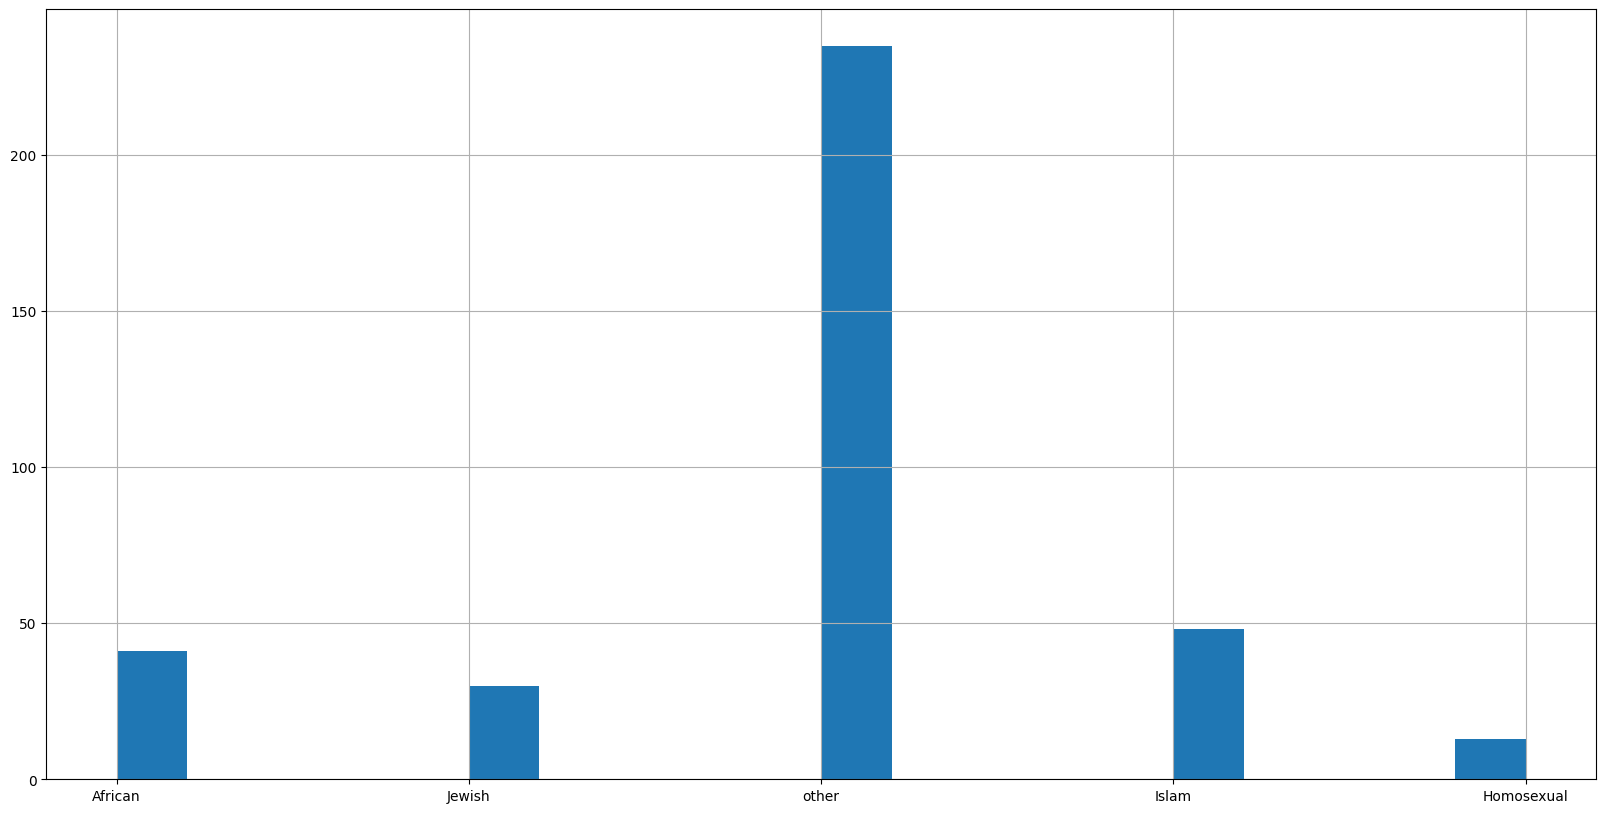

In [30]:
res_df['pred'].hist(figsize=(20,10),bins=20)

In [31]:
g_hate_df = res_df.groupby(['topics', 'pred']).count()['text'].reset_index()
p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.topics, index=g_hate_df.pred)
p_g_hate_df.columns = p_g_hate_df.columns.droplevel(0)
p_g_hate_df = p_g_hate_df.reindex(['other','African' ,'Islam', 'Jewish', 'Homosexual'])
n_p_g_hate_df = p_g_hate_df.apply(lambda x: x/x.sum(), axis=1)#.drop(columns=['-1_user_nigger_number_white'])

<AxesSubplot:xlabel='topics', ylabel='pred'>

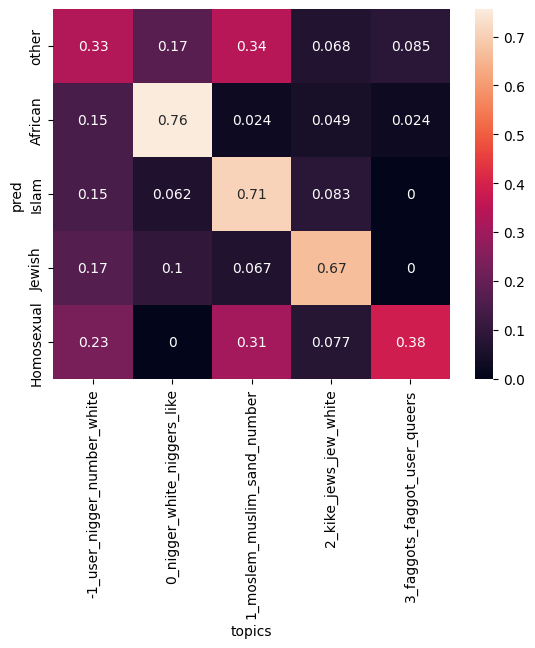

In [32]:
import seaborn as sns
sns.heatmap(n_p_g_hate_df.fillna(0), annot=True)

In [125]:
res_df[res_df['pred']=='other'].label_mean.mean()

4.402605828825348

In [35]:
res_df.to_csv(r'../data/for_annottating.csv')

In [30]:
view = res_df[(res_df['pred']!='other')&(res_df['topics']!='-1_user_nigger_number_white')&(res_df['label_mean']==5)]

In [31]:
view.sample(20)

,id,text,label_mean,disputable_post,lang,topics,pred
531,e04e199fa5a24ea4b0ca2264345b473d,the brits are the most politically correct peo...,5.0,False,en,1_moslem_muslim_sand_number,Islam
2196,42b2b3ad47a54347aa85bccea1755aba,there (tm) s nothing i like more than hearing ...,5.0,False,en,0_nigger_white_niggers_like,African
49,991dbab436b54d9b829df42f002748a1,"now the blacks not only want welfare , free co...",5.0,False,en,0_nigger_white_niggers_like,African
977,4df1c6e57ae54be19a89acc8f3448083,my advise today . do not ever trust a muslim ....,5.0,False,en,1_moslem_muslim_sand_number,Islam
66,2120be390d02480ba91a41c6cc99d621,listening to chuckie and pelosi aboyt isis ! i...,5.0,False,en,1_moslem_muslim_sand_number,Jewish
8160,55017ea921f64725964da6966189cc86,the return of jim crow laws . this is no diffe...,5.0,False,en,2_kike_jews_jew_white,Homosexual
7165,8cfd3fb469ea4e6f95716e0eca057ec4,these stupid iranians ... nuke them,5.0,False,en,1_moslem_muslim_sand_number,Jewish
1267,a8f6391f2fdc49e89faf9fcd629b0c41,"i (tm) m doing it wrong d y ~ ' nigger , jew c...",5.0,False,en,0_nigger_white_niggers_like,African
8303,5d6511a7bb974f39b0e2f98a1c86d76a,kanye west : planned parenthood founded ' to k...,5.0,False,en,0_nigger_white_niggers_like,African
3236,d214a6e8ac0e47b9b7304bddcf243e67,negroids are useful to the patriot white pride...,5.0,False,en,0_nigger_white_niggers_like,African


In [32]:
view.loc[3767].text

"d y ' y= 1/4 i , read this 1/4 i , d y ' y= i hope this is a spoof . if not ... this is some sick shit . dont forget this radical islamic b * tch was actually potus from 2009-2017 ! sorry <user> ... <user> was the first female potus 1/4 i , d y ~ !"

In [33]:
nlp(view.loc[8383].text)._.language

{'language': 'en', 'score': 0.9999984991303407}

In [128]:
res_df

,id,text,label_mean,disputable_post,lang,topics,pred
1,bb348c5f20a84be1bc3467d32312341c,biden and his supporters are claiming that bid...,4.0,True,en,-1_user_nigger_number_white,other
5,61b45f2913bd44a8956ee87cc651cd40,"d y "" ' j i , j i , j i , j i , j i , j i , j ...",4.4,False,en,-1_user_nigger_number_white,other
13,fa08b4c9573e43bab2a2700ecb25e1d8,so tired of all the leftist shite . the uk is ...,4.4,False,en,-1_user_nigger_number_white,other
32,a8c557bbf70849aa9fed0d2217fdd5a2,here is a message for juan williams ! joe bide...,4.4,False,en,-1_user_nigger_number_white,other
47,35d2a80bef014478a2dc4b752e31eba6,i just listened to a great podcast on the rush...,4.6,False,en,1_moslem_muslim_sand_number,African
...,...,...,...,...,...,...,...
9998,4013bfbd0f2f498ca542a8f096d3183d,if you are still a democrat at this stage in t...,4.5,False,en,-1_user_nigger_number_white,other
10025,21e84daebead49f29902f4ef1832cc23,blm are george soros 's murderers that 's what...,4.0,False,en,0_nigger_white_niggers_like,other
10030,1e9c833671d549d98a265deccc20fdce,""" being black is building pyramids , not the c...",4.5,False,en,0_nigger_white_niggers_like,African
10031,fcc43f049086447ba2b267e233583047,fucking liberal bullshit !,4.0,False,en,1_moslem_muslim_sand_number,other
